In [ ]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# Function to unpickle a batch
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
# Dataset path
data_dir = "/content/cifar_test_nolabel.pkl"

In [ ]:
# Load the batch
batch_data = unpickle(data_dir)

# Check available keys
print("Keys in batch_data:", batch_data.keys())

# Extract images (no need to reshape if already correct)
X_train = np.array(batch_data[b'data'])
X_train = X_train.astype("float32") / 255.0
print("Final X_train shape:", X_train.shape)  # Expected (10000, 32, 32, 3)

Keys in batch_data: dict_keys([b'data', b'ids'])
Final X_train shape: (10000, 32, 32, 3)


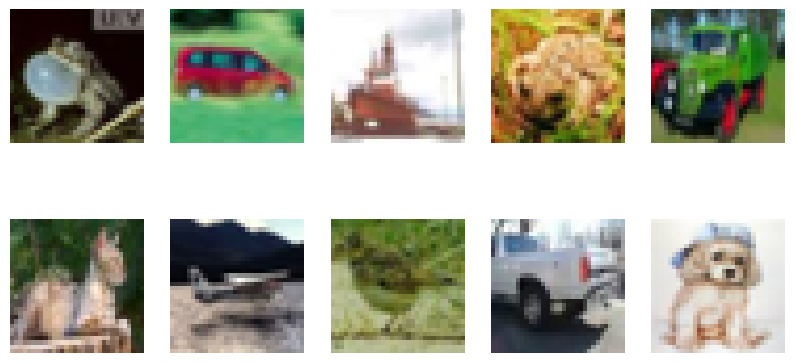

In [ ]:
# Visualize some images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])  # Display first 10 images
    ax.axis('off')
plt.show()

## Mean and Std

In [ ]:
# Compute mean and standard deviation across the dataset
mean = np.mean(X_train, axis=(0, 1, 2))  # Per-channel mean
std = np.std(X_train, axis=(0, 1, 2))    # Per-channel std deviation

print("Mean per channel:", mean)
print("Standard deviation per channel:", std)

Mean per channel: [0.5130185  0.49718732 0.46153724]
Standard deviation per channel: [0.263369   0.25981212 0.27293345]


As test data has higher mean and std than train (CIFAR-10's mean and std), it means:
* The test images already have more diverse brightness, saturation, and contrast than training images.
* If applied too much color jitter while training, the model may learn unnatural variations that don’t match the real test set distribution.
* Instead, should focus on positional augmentations (cropping, flipping, rotation) to improve generalization.

## Trying clustering to see if images can be categorized based on the color

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 10  # Since CIFAR-10 has 10 classes
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_train_resnet)

print("Cluster assignments:", np.unique(clusters, return_counts=True))

Cluster assignments: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), array([ 669, 1110, 1462,  270, 1811, 1592, 1105,  727,  437,  817]))


Some cluster seem to have high number of images while some very few. So, concluded that images cannot be grouped based on colors for prediction

## Understanding edges

In [ ]:
edge_strengths = []

for img in X_train:
    edges = apply_sobel(img)  # Apply Sobel filter
    edge_strengths.append(np.mean(edges))  # Store mean edge intensity

# Convert to NumPy array
edge_strengths = np.array(edge_strengths)

# Compute statistics
mean_edge_strength = np.mean(edge_strengths)
std_edge_strength = np.std(edge_strengths)

print(f"Mean Edge Strength: {mean_edge_strength:.2f}")
print(f"Edge Strength Standard Deviation: {std_edge_strength:.2f}")

Mean Edge Strength: 6.92
Edge Strength Standard Deviation: 1.94


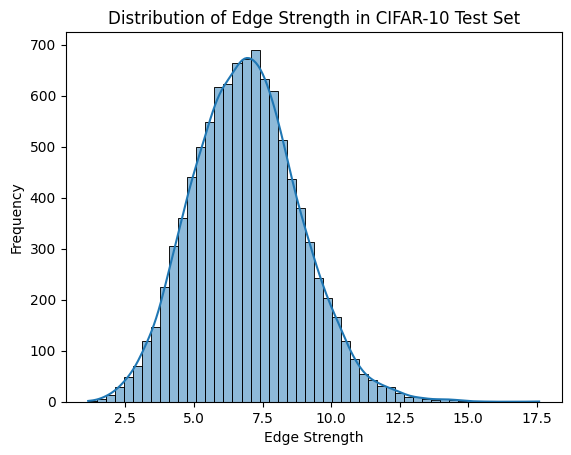

In [ ]:
import seaborn as sns

sns.histplot(edge_strengths, bins=50, kde=True)
plt.xlabel("Edge Strength")
plt.ylabel("Frequency")
plt.title("Distribution of Edge Strength in CIFAR-10 Test Set")
plt.show()


Strong Edge Images: 1550
Weak Edge Images: 1630


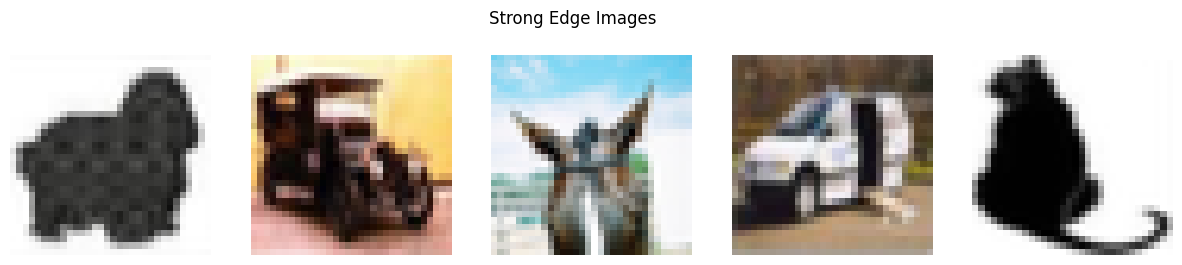

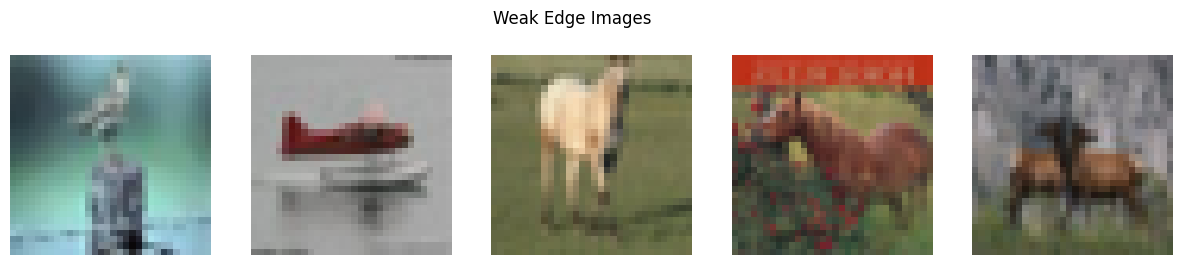

In [ ]:
strong_edges_idx = np.where(edge_strengths > mean_edge_strength + std_edge_strength)[0] # images whose edge strength is more than one standard deviation away from the mean
weak_edges_idx = np.where(edge_strengths < mean_edge_strength - std_edge_strength)[0]

print(f"Strong Edge Images: {len(strong_edges_idx)}")
print(f"Weak Edge Images: {len(weak_edges_idx)}")

# Plot strong edge images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[strong_edges_idx[i]])
    ax.axis('off')
plt.suptitle("Strong Edge Images")
plt.show()

# Plot weak edge images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[weak_edges_idx[i]])
    ax.axis('off')
plt.suptitle("Weak Edge Images")
plt.show()

1630 images seem to have weak edges. So, applying contrast enhancement to weak edge images in the training set can be a useful targeted augmentation strategy, but it should be used selectively.

## Histogram of background color

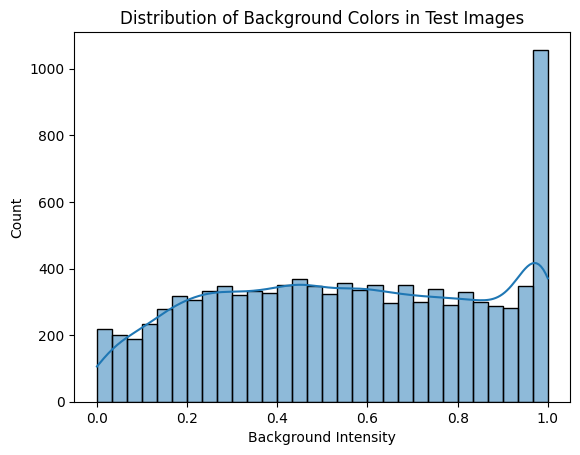

In [ ]:
# Compute background intensity (assuming background is the most frequent pixel)
background_intensity = np.mean(X_train[:, :2, :2, :], axis=(1, 2, 3))  # Mean intensity of top-left corner

# Plot histogram
sns.histplot(background_intensity, bins=30, kde=True)
plt.xlabel("Background Intensity")
plt.title("Distribution of Background Colors in Test Images")
plt.show()


Histogram of background color intensity in test images shows that:
1. Peak at Intensity 1.0:
    * Many images have a completely white background.
    * This suggests that some images have plain white regions in the corners.
2. Uniform Distribution in Middle Values (0.2 - 0.8):
    * The test set has a wide variety of background colors.
    * This means some images have complex backgrounds, while others have uniform ones.

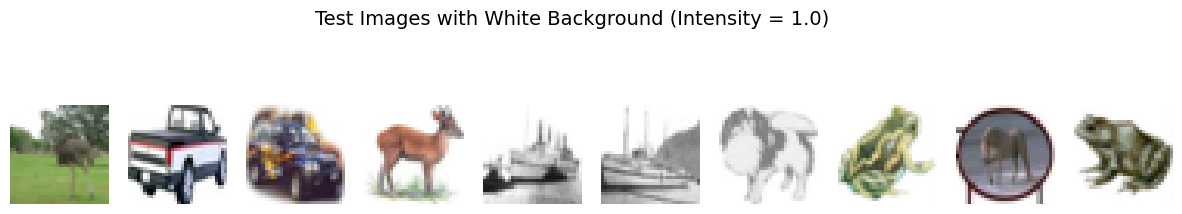

In [ ]:
# Compute background intensity (mean intensity of the top-left 2×2 region)
background_intensity = np.mean(X_train[:, :2, :2, :], axis=(1, 2, 3))  # Assuming X_test is test set images

# Find indices of images where background intensity is exactly 1.0
white_bg_indices = np.where(background_intensity == 1.0)[0]

# Select up to 10 images with white background for visualization
num_images = min(10, len(white_bg_indices))  # Show max 10 images
selected_indices = np.random.choice(white_bg_indices, num_images, replace=False)

# Plot the selected images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[selected_indices[i]])  # Show images
    ax.axis('off')  # Hide axes
plt.suptitle("Test Images with White Background (Intensity = 1.0)", fontsize=14)
plt.show()


Now that we confirmed some test images have white backgrounds, we can adjust training strategy: by
1. transforms.ColorJitter(brightness=0.1, contrast=0.1)  # Keep light color jitter
2. Use cutout

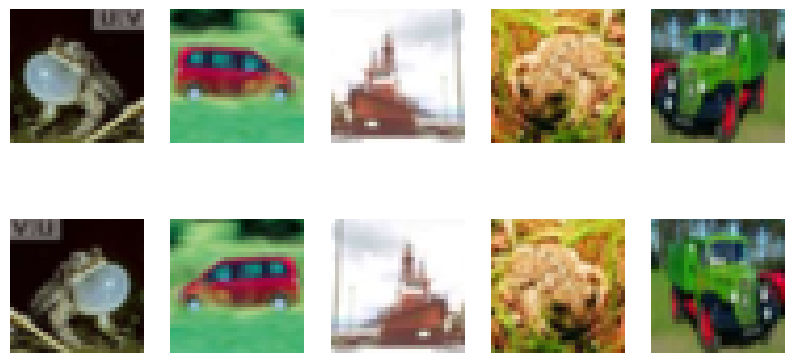

In [ ]:
# Flip test images horizontally
X_flipped = tf.image.flip_left_right(X_train)

# Show some original vs flipped images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    axes[0, i].imshow(X_train[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(X_flipped[i])
    axes[1, i].axis('off')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce features before clustering
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_train.reshape(len(X_train), -1))

# Cluster images
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

print("Cluster distribution:", np.bincount(clusters))

Cluster distribution: [1162 1069 1005 1097  982  970 1483  845  622  765]


Cluster 0:


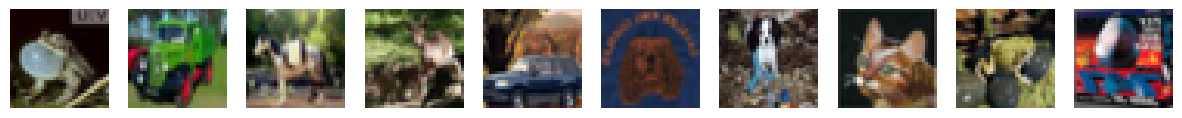

Cluster 1:


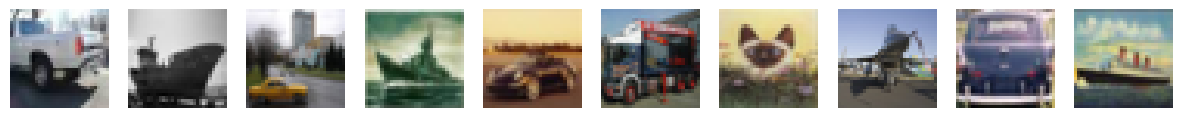

Cluster 2:


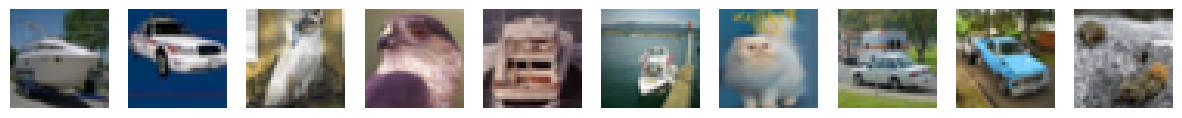

Cluster 3:


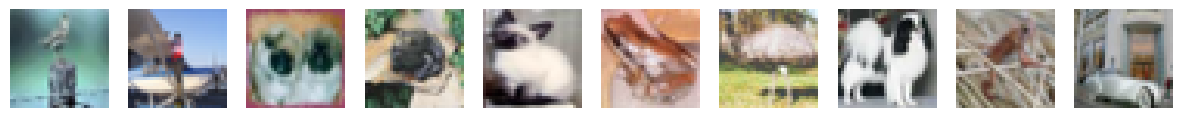

Cluster 4:


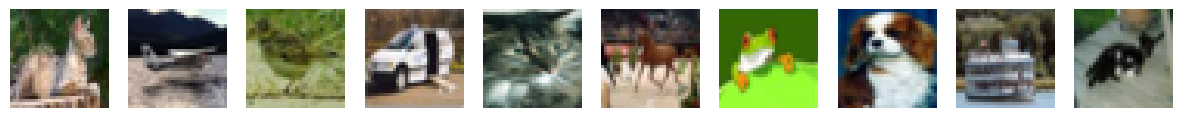

Cluster 5:


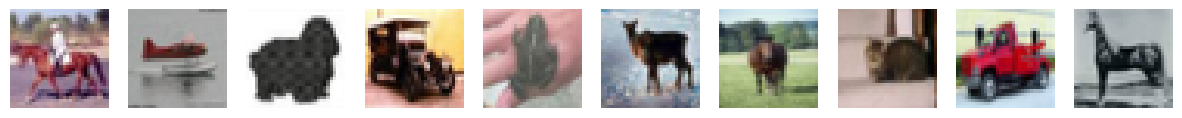

Cluster 6:


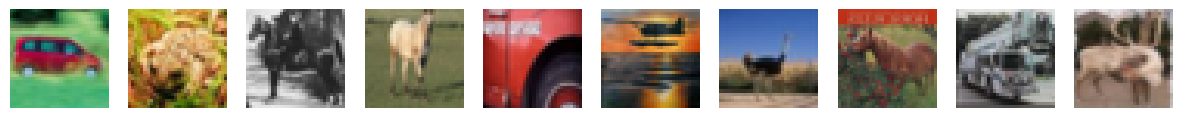

Cluster 7:


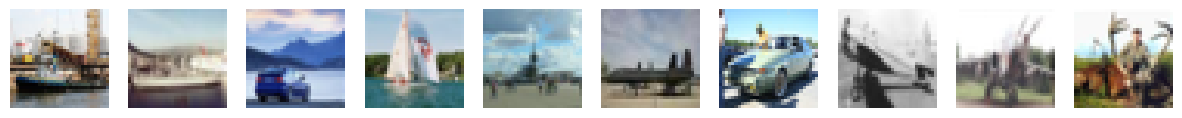

Cluster 8:


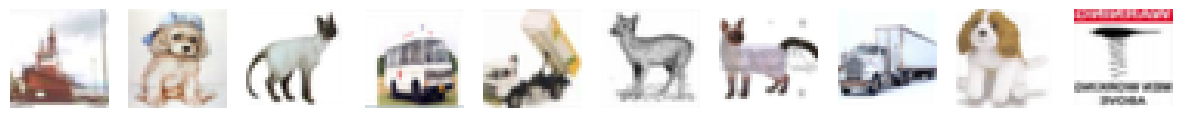

Cluster 9:


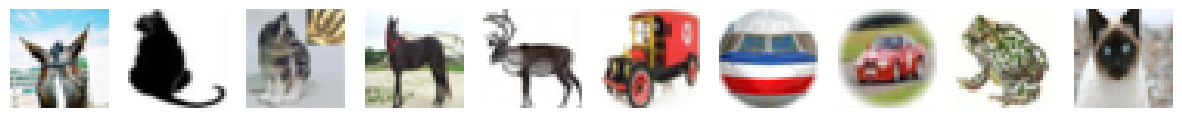

In [ ]:
import matplotlib.pyplot as plt

def plot_cluster_images(images, cluster_assignments, cluster_num, num_images=10):
    """ Visualize images from a specific cluster. """
    indices = np.where(cluster_assignments == cluster_num)[0][:num_images]

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[indices[i]])
        ax.axis('off')
    plt.show()

# Show images from each cluster
for i in range(10):  # Iterate over 10 clusters
    print(f"Cluster {i}:")
    plot_cluster_images(X_train, clusters, i)
